# Preprocessing a WSI: From raw image to analysis-ready data

Welcome to the second tutorial in our LazySlide series! In this lesson, we'll walk you through a complete workflow for preprocessing whole slide images (WSIs). Preprocessing is a crucial step that transforms raw WSI data into a format that's ready for advanced analysis.

By the end of this tutorial, you'll understand how to:
- Load and examine WSI data
- Segment tissue regions from the background
- Evaluate tissue quality
- Create tiles (smaller patches) from large WSIs
- Extract meaningful features from these tiles

Let's get started with this essential foundation for computational pathology!

## Setting up environment

Let's start by importing the LazySlide library. Throughout all our tutorials, we'll use the convention of importing LazySlide as `zs` - this makes our code consistent and easy to read. This naming convention is similar to how other popular libraries like pandas (`pd`) and numpy (`np`) are typically imported.

In [1]:
import lazyslide as zs

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Step 1: Opening a whole slide image

Our first task is to load a whole slide image for processing. For this tutorial, we'll download a sample artery tissue slide from the GTEx project. This is the same slide we explored in the previous tutorial, so you should already be familiar with its basic structure.

In [5]:
from huggingface_hub import hf_hub_download

slide = hf_hub_download(
    "rendeirolab/lazyslide-data", 
    "GTEX-1117F-0526.svs", 
    repo_type="dataset",
    cache_dir="."
)

## Step 2: Understanding the WSIData object

A key concept in LazySlide is the `WSIData` object, which is the foundation of our analysis workflow. Let's take a moment to understand what makes this object so powerful:

- `WSIData` extends the `SpatialData` framework, adding specialized capabilities for working with whole slide images
- It provides a unified interface for accessing both the image data and associated metadata regardless of your WSI format
- It's compatible with other packages in the scverse ecosystem, allowing for seamless integration with single-cell analysis tools
- It maintains a connection to your original WSI file while storing analysis results separately

When you open a WSI, the system automatically creates a `WSIData` object. By default, this object is stored in a directory alongside your original WSI file, making it easy to find and reuse your analysis results later.

If you're interested in learning more about the technical details, you can explore the [WSIData documentation](https://wsidata.readthedocs.io/en/latest/intro/index.html).

Now, let's create our WSIData object:

In [6]:
from wsidata import open_wsi

wsi = open_wsi(slide)

## Step 3: Exploring WSIData object

Let's examine what's inside our newly created WSIData object. This will help us understand the structure and components that we'll be working with throughout our analysis.

WSI: datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
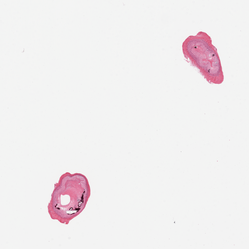

In [7]:
wsi

Now, let's examine the important metadata of our slide. This information tells us crucial details about how the slide was scanned and its dimensions. For example, we can see that this slide was scanned at 20X magnification with a resolution of 0.4942 microns per pixel (mpp). We can also see that the full-resolution image has dimensions of 19958×19919 pixels - that's nearly 400 million pixels in total!

In [8]:
wsi.properties

Field,Value
shape,"[19958, 19919]"
n_level,3
level_shape,"[[19958, 19919], [4989, 4979], [2494, 2489]]"
level_downsample,"[1.0, 4.000501706284455, 8.002609074152414]"
mpp,0.4942
magnification,20.0
bounds,"[0, 0, 19919, 19958]"


Let's visualize our slide to get a better understanding of what we're working with. LazySlide makes it easy to render a whole slide image with just a single line of code using the `tissue` function from the plotting module.

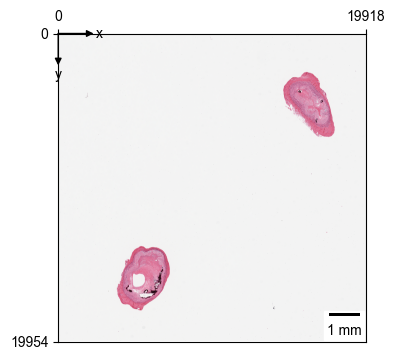

In [9]:
zs.pl.tissue(wsi)

### Saving Our Work

An important aspect of working with WSIData is that all changes are initially stored in memory. To preserve our work between sessions, we need to save it to disk. This can be done easily with the `.write()` method. By default, this saves our WSIData in a directory right next to our original slide file. This will not only make it easier for you to locate the store but it will also be automatically picked up when you open a WSI.

In [10]:
wsi.write()

INFO     The Zarr backing store has been changed from None the new file path:                                      
         datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.z
         arr                                                                                                       


## Step 4: Tissue Segmentation

One of the most fundamental steps in WSI analysis is tissue segmentation - the process of identifying and isolating the actual tissue regions from the background and artifacts. This step is crucial because:

1. It reduces the computational burden by focusing only on relevant areas
2. It eliminates background areas that could introduce noise into our analysis
3. It allows us to work with distinct tissue pieces separately

LazySlide provides powerful tools to automatically detect tissue regions. Let's see how this works:

In [11]:
zs.pp.find_tissues(wsi)

Let's visualize the results of our tissue segmentation to make sure it worked correctly. In the visualization:
- The <span style="color: #117554;">green lines</span> show the borders of detected tissue regions
- The <span style="color: #4379F2;">blue areas</span> represent holes or empty spaces within the tissue that will be excluded from analysis

The default parameters of the tissue segmentation algorithm usually work quite well for most slides, but LazySlide offers many options to fine-tune the segmentation if needed.

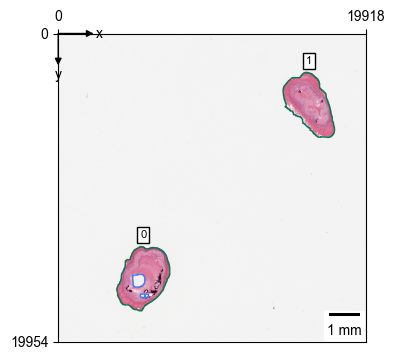

In [12]:
zs.pl.tissue(wsi)

### Examining the segmentation results

If we examine our WSIData object again, we'll notice something new: a `GeoDataFrame` named `tissues` has been added to the `Shapes` slot in our SpatialData object. This is where LazySlide stores the geometric information about each tissue region we've identified.

WSI: datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /Users/yzheng/Projects/LazySlide/docs/source/tutorials/datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
└── Shapes
      └── 'tissues': GeoDataFrame shape: (2, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tissues (Shapes)
with the following elements not in the Zarr store:
    ▸ tissues (Shapes)
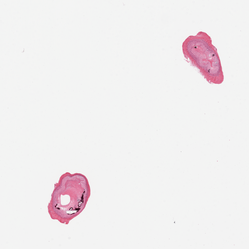

In [13]:
wsi

We can access this table using dictionary-style notation with the key "tissues". Let's take a look at what information is stored for each tissue region:

Each row in this table represents a distinct tissue piece, and each tissue is assigned a unique `tissue_id`. This identifier is extremely useful as it allows us to:
1. Reference specific tissue pieces in our analysis
2. Track tissue pieces across different processing steps
3. Apply operations to individual tissues rather than the entire slide

You might have noticed that these `tissue_id` values were also displayed in our earlier visualization, making it easy to connect what we see visually with the data in our tables.

In [14]:
wsi["tissues"]

,tissue_id,geometry
0,0,"POLYGON ((5345.743 13804.501, 5337.74 13812.50..."
1,1,"POLYGON ((16029.226 2520.822, 16021.223 2528.8..."


### Focusing on individual tissue pieces

One of the advantages of tissue segmentation is the ability to focus on specific regions of interest. LazySlide makes it easy to zoom in on a particular tissue piece by specifying its `tissue_id` in the visualization function. This is particularly useful when working with slides that contain multiple distinct tissue sections.

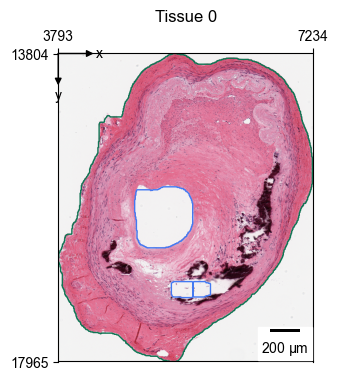

In [15]:
zs.pl.tissue(wsi, tissue_id=0)

You may also show all tissue pieces at once by specifying `tissue_id="all"`

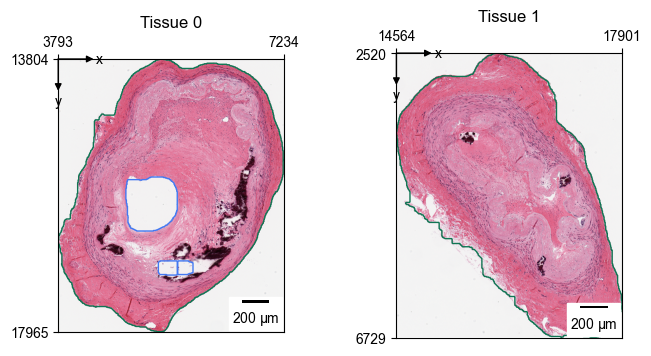

In [16]:
zs.pl.tissue(wsi, tissue_id="all")

### Don't forget to save your work!

Remember that all the processing we've done so far (tissue segmentation, etc.) is stored in memory until we explicitly save it. It's a good practice to save your work periodically, especially after completing important processing steps. This ensures you won't lose your progress if your session ends unexpectedly.

In [17]:
wsi.write()

### Loading previously saved work

One of the great benefits of saving your work is that you can easily pick up where you left off in a future session. LazySlide automatically looks for existing WSIData when you open a slide, making it seamless to continue your analysis:

In [18]:
wsi = open_wsi(slide)

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


## Advanced topic: Deep learning-based tissue segmentation

In addition to the traditional image processing techniques we've used so far, LazySlide also offers more advanced deep learning-based approaches to tissue segmentation.

Let's try the deep learning-based segmentation approach:

In [19]:
zs.seg.tissue(wsi, key_added="dl-tissues")

WSI: datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /Users/yzheng/Projects/LazySlide/docs/source/tutorials/datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
└── Shapes
      ├── 'dl-tissues': GeoDataFrame shape: (2, 2) (2D shapes)
      └── 'tissues': GeoDataFrame shape: (2, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), dl-tissues (Shapes), tissues (Shapes)
with the following elements not in the Zarr store:
    ▸ dl-tissues (Shapes)
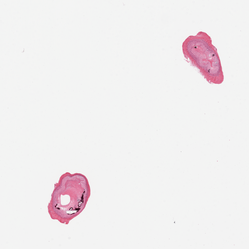

In [20]:
wsi

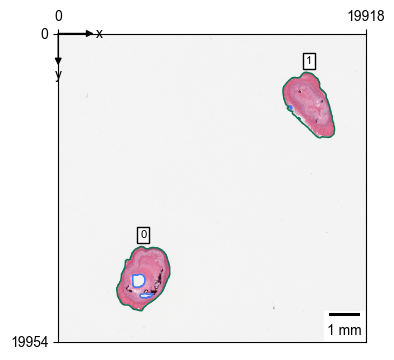

In [21]:
zs.pl.tissue(wsi, tissue_key="dl-tissues")

## Calculating tissue properties

Beyond just identifying tissue regions, it's often valuable to calculate various geometric properties of each tissue piece. These properties can provide insights into tissue morphology and can be used as features in downstream analysis.

LazySlide makes it easy to calculate a comprehensive set of geometric properties for each tissue instance, including:
- Area and perimeter
- Compactness and roundness
- Major and minor axis lengths
- Orientation and eccentricity

Let's calculate these properties for our tissue pieces:

In [22]:
zs.tl.tissue_props(wsi)

In [23]:
wsi["tissues"]

,tissue_id,geometry,area,area_filled,convex_area,solidity,convexity,axis_major_length,axis_minor_length,eccentricity,...,moment-mu21,moment-mu12,moment-mu03,moment-nu20,moment-nu11,moment-nu02,moment-nu30,moment-nu21,moment-nu12,moment-nu03
0,0,"POLYGON ((5345.743 13804.501, 5337.74 13812.50...",9295453.0,9962045.0,10318845.0,0.900823,1.110096,4348.672363,2953.654297,0.733946,...,1.881723e+14,-5.012970e+14,6.182167e+13,0.068301,-0.026006,0.104072,0.000592,0.000601,-0.001600,0.000197
1,1,"POLYGON ((16029.226 2520.822, 16021.223 2528.8...",8684173.0,8684173.0,9086193.5,0.955755,1.046293,4684.261719,2505.699219,0.844904,...,6.244954e+14,1.792367e+15,1.164329e+15,0.074724,0.048856,0.123623,-0.002956,0.002810,0.008065,0.005239


## Step 5: Tiling - Breaking down the WSI into manageable pieces

We've now reached one of the most important preprocessing steps: tiling (also called patching). This process involves dividing the large whole slide image into smaller, manageable pieces that can be processed individually.

### Why tiling is essential

Tiling solves several critical challenges in WSI analysis:
1. **Memory constraints**: As we've discussed, whole slide images are enormous (often several GB) and cannot fit entirely into memory
2. **Computational efficiency**: Working with smaller tiles allows for parallel processing and faster analysis
3. **Feature extraction**: Most deep learning models expect inputs of a fixed size, making tiles ideal for feature extraction
4. **Localized analysis**: Tiling preserves spatial information while allowing for detailed analysis of specific regions

### Harmonization Across Slides

:::{note}
When working with multiple slides from different sources, harmonization becomes crucial to account for batch effects. If your slides were scanned at different magnifications, you should specify a consistent microns-per-pixel (mpp) value during tiling to ensure all tiles represent the same physical area, regardless of the original scanning resolution.
:::

Here is a list of mpp value map with magnification:
<table>
    <thead>
        <tr>
            <th>Magnification</th>
            <th>MPP (Microns per Pixel)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>40×</td>
            <td>0.25</td>
        </tr>
        <tr>
            <td>20×</td>
            <td>0.5</td>
        </tr>
        <tr>
            <td>10×</td>
            <td>1</td>
        </tr>
    </tbody>
</table>

### LazySlide's flexible tiling capabilities

LazySlide offers exceptional flexibility when it comes to tiling, you can:
- Request tiles at any magnification level, not just the native scanning magnification (Upsampling is not allowed though)
- Specify any tile size that suits your analysis needs
- Control the amount of overlap between adjacent tiles
- Focus tiling on specific tissue regions, avoiding empty background areas

By default, tiles are created without overlapping to avoid redundancy. All the parameters used for tiling are stored in a `tile_spec` object, which helps maintain consistency and reproducibility in your analysis. Let's examine what this specification looks like:

In [24]:
zs.pp.tile_tissues(wsi, 256, mpp=0.5)
wsi.tile_spec("tiles")

Tile at 0.5 mpp, 256×256 (h×w)
Stride: 256×256 (0×0 overlap)
Operation size: 259×259, level=0
Base size: 259×259, level=0
Target tissue: 'tissues'

### Creating overlapping tiles

In some analysis scenarios, it's beneficial to have overlapping tiles. For example:
- When analyzing tissue structures that might cross tile boundaries
- When applying algorithms that perform better with context from neighboring regions
- Segmentation tasks

LazySlide allows you to control the amount of overlap by specifying the overlap (from 0 to 1) or stride size (the distance between the starting points of adjacent tiles). A stride smaller than the tile size creates overlapping tiles:

In [25]:
# If use overlap
zs.pp.tile_tissues(wsi, 256, overlap=0.1, mpp=0.5, key_added="tile_overlap_0.1")
# If use stride_px
zs.pp.tile_tissues(wsi, 256, stride_px=200, mpp=0.5, key_added="tile_stride_200")
wsi.tile_spec("tile_stride_200")

Tile at 0.5 mpp, 256×256 (h×w)
Stride: 200×200 (56×56 overlap)
Operation size: 259×259, level=0
Base size: 259×259, level=0
Target tissue: 'tissues'

### The tiling result

After tiling, LazySlide stores all tile information in a `GeoDataFrame` (by default named `tiles`).

Each tile is linked to its parent tissue through the `tissue_id` column, maintaining the hierarchical relationship between tissues and tiles. Let's examine the tiles data:

In [26]:
wsi["tiles"]

,tile_id,tissue_id,geometry
0,0,0,"POLYGON ((4052 16394, 4052 16653, 3793 16653, ..."
1,1,0,"POLYGON ((4052 16653, 4052 16912, 3793 16912, ..."
2,2,0,"POLYGON ((4311 15617, 4311 15876, 4052 15876, ..."
3,3,0,"POLYGON ((4311 15876, 4311 16135, 4052 16135, ..."
4,4,0,"POLYGON ((4311 16135, 4311 16394, 4052 16394, ..."
...,...,...,...
248,248,1,"POLYGON ((17672 5887, 17672 6146, 17413 6146, ..."
249,249,1,"POLYGON ((17672 6146, 17672 6405, 17413 6405, ..."
250,250,1,"POLYGON ((17672 6405, 17672 6664, 17413 6664, ..."
251,251,1,"POLYGON ((17931 5887, 17931 6146, 17672 6146, ..."


tiles can be visualized using the `tiles` function in plotting module.

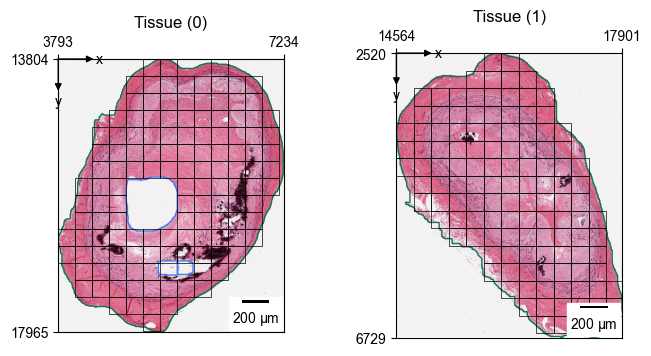

In [27]:
zs.pl.tiles(wsi, tissue_id="all", linewidth=0.5)

### Evaluating tile quality

Just as we evaluated the quality of entire tissue regions earlier, we can also assess the quality of individual tiles. This is particularly important because not all tiles are equally informative or suitable for analysis. Some tiles might be:
- Out of focus
- Contain scanning artifacts
- Have poor contrast
- Contain mostly background or whitespace

LazySlide provides prediction models specifically designed for tiles. Let's apply a QC model from [pathprofiler](https://github.com/MaryamHaghighat/PathProfiler/tree/master):

In [28]:
zs.tl.tile_prediction(wsi, 'pathprofilerqc')

Output()

In [29]:
wsi["tiles"]

,tile_id,tissue_id,geometry,diagnostic_quality,visual_cleanliness,focus_issue,staining_issue,tissue_folding_present,misc_artifacts_present
0,0,0,"POLYGON ((4052 16394, 4052 16653, 3793 16653, ...",0.662936,0.199004,0.481060,0.548514,0.071819,0.116296
1,1,0,"POLYGON ((4052 16653, 4052 16912, 3793 16912, ...",0.742658,0.123765,0.385887,0.442843,0.037424,0.075099
2,2,0,"POLYGON ((4311 15617, 4311 15876, 4052 15876, ...",0.794227,0.140606,0.265492,0.384464,0.278130,0.272866
3,3,0,"POLYGON ((4311 15876, 4311 16135, 4052 16135, ...",0.741334,0.148304,0.251487,0.435380,0.250680,0.478446
4,4,0,"POLYGON ((4311 16135, 4311 16394, 4052 16394, ...",0.755080,0.191110,0.238106,0.330548,0.427208,0.439598
...,...,...,...,...,...,...,...,...,...
248,248,1,"POLYGON ((17672 5887, 17672 6146, 17413 6146, ...",0.817582,0.113575,0.195133,0.456226,0.333128,0.170222
249,249,1,"POLYGON ((17672 6146, 17672 6405, 17413 6405, ...",0.946041,0.317217,0.319121,0.339665,0.160872,0.009316
250,250,1,"POLYGON ((17672 6405, 17672 6664, 17413 6664, ...",0.739553,-0.001332,0.384507,0.359757,0.137283,0.376323
251,251,1,"POLYGON ((17931 5887, 17931 6146, 17672 6146, ...",0.766454,0.190119,0.464746,0.309865,-0.029028,0.170172


### Visualizing tile quality scores

After calculating quality scores, it's helpful to visualize them to identify patterns or problematic regions. LazySlide makes this easy by allowing you to color tiles based on any numerical property in the tiles dataframe.

Let's visualize the contrast scores we just calculated:

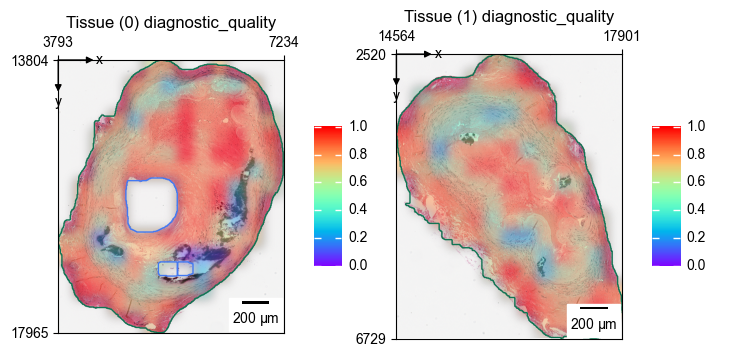

In [30]:
zs.pl.tiles(wsi, tissue_id="all", color="diagnostic_quality", cmap="rainbow", 
            smooth=True, alpha=.5, vmin=0, vmax=1)

## Step 6: Feature extraction - transforming images into numerical representations

We've now reached a crucial step in our preprocessing pipeline: feature extraction. This process transforms our image tiles into numerical representations (feature vectors) that capture the morphological characteristics of the tissue.

### Why feature extraction matters

Feature extraction is essential because:
1. It converts complex visual information into a format that machine learning algorithms can process
2. It enables quantitative comparison between different tissue regions
3. It forms the foundation for tasks like classification, clustering, and anomaly detection

### Using vision models for feature extraction

The most effective way to extract meaningful features from histology images is to use pre-trained vision models. These models, often trained on millions of images, have learned to recognize patterns and structures that are relevant to many visual tasks.

LazySlide supports a wide range of vision models:
- Standard architectures from the `timm` library (ResNet, DenseNet, EfficientNet, etc.)
- Specialized pathology foundation models
- Custom models that you can provide

You can explore the available timm models with:
```python
import timm
timm.list_models()
```

In [31]:
zs.tl.feature_extraction(wsi, "resnet50")

Output()

### Using foundation models for pathology

While general-purpose vision models like ResNet50 work well for many tasks, LazySlide also provides access to specialized foundation models that have been specifically trained on histology images. These models often capture pathology-specific features more effectively.

Let's see what foundation models are available:

In [32]:
zs.models.list_models()[0:8]

['conch', 'plip', 'prism', 'titan', 'conch_v1.5', 'uni', 'uni2', 'gigapath']

:::{note}
Some foundation models require access permissions from their creators. If you encounter an access error, you'll need to:
1. Request access at the corresponding Hugging Face repository
2. [Generate a token](https://huggingface.co/docs/hub/security-tokens) from your Hugging Face account
3. [Login using the token](https://huggingface.co/docs/huggingface_hub/en/guides/cli#huggingface-cli-login)

To run feature extraction on a foundation model:

```python
zs.tl.feature_extraction(wsi, "uni2")
```

WSI: datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /Users/yzheng/Projects/LazySlide/docs/source/tutorials/datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
├── Shapes
│     ├── 'dl-tissues': GeoDataFrame shape: (2, 2) (2D shapes)
│     ├── 'tile_overlap_0.1': GeoDataFrame shape: (311, 3) (2D shapes)
│     ├── 'tile_stride_200': GeoDataFrame shape: (415, 3) (2D shapes)
│     ├── 'tiles': GeoDataFrame shape: (253, 9) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (2, 51) (2D shapes)
└── Tables
      └── 'resnet50_tiles': AnnData (253, 2048)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), dl-tissues (Shapes), tile_overlap_0.1 (Shapes), tile_stride_200 (Shapes), tiles (Shapes), tissues (Shapes)
with the following elements not in the Zarr store:
    ▸ resnet50_tiles (Tables)
    ▸ tile_overlap_0.1 (Shapes)
    ▸ dl-tissues (Shapes)
    ▸ tile_stride_200 (Shapes)
    ▸ tiles (Shapes)
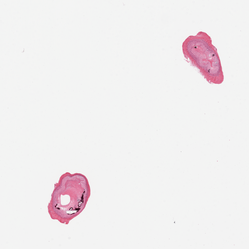

In [33]:
wsi

Features are saved as `AnnData` store with a convention of "{model name}_{tiles key}".

### Feature aggregation basics

To perform analysis across dataset, a usual way is to pool features into a 1D vector that can represent the entire slide.

Features can be aggregated at different levels, such as slide-level and tissue-level.

In [34]:
zs.tl.feature_aggregation(wsi, "resnet50")
zs.tl.feature_aggregation(wsi, "resnet50", by="tissue_id")

In [35]:
wsi["resnet50_tiles"]

AnnData object with n_obs × n_vars = 253 × 2048
    obs: 'tile_id', 'library_id'
    uns: 'spatialdata_attrs', 'agg_ops'
    varm: 'agg_slide', 'agg_tissue_id'

In [36]:
wsi.fetch.features_anndata("resnet50")

AnnData object with n_obs × n_vars = 253 × 2048
    obs: 'tile_id', 'tissue_id', 'diagnostic_quality', 'visual_cleanliness', 'focus_issue', 'staining_issue', 'tissue_folding_present', 'misc_artifacts_present'
    uns: 'tile_spec', 'slide_properties'
    obsm: 'spatial'
    varm: 'agg_slide', 'agg_tissue_id'

## Save on the disk

Now that we finished with our preprocessing. Remember to save the wsidata. By default it is saved side by side with the WSI. When you open the WSI next time, it will automatically pick up the wsidata.

In [37]:
wsi.write()

Notice that after saving, your `SpatialData` is now associated with a disk storage.

WSI: datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /Users/yzheng/Projects/LazySlide/docs/source/tutorials/datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
├── Shapes
│     ├── 'dl-tissues': GeoDataFrame shape: (2, 2) (2D shapes)
│     ├── 'tile_overlap_0.1': GeoDataFrame shape: (311, 3) (2D shapes)
│     ├── 'tile_stride_200': GeoDataFrame shape: (415, 3) (2D shapes)
│     ├── 'tiles': GeoDataFrame shape: (253, 9) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (2, 51) (2D shapes)
└── Tables
      └── 'resnet50_tiles': AnnData (253, 2048)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), dl-tissues (Shapes), tile_overlap_0.1 (Shapes), tile_stride_200 (Shapes), tiles (Shapes), tissues (Shapes)
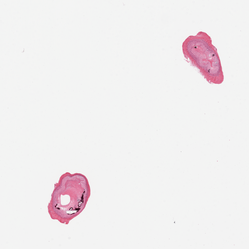

In [38]:
wsi

You can always change where it should be saved

In [39]:
# Clean up the disk content
import shutil

shutil.rmtree(wsi.wsi_store)

In [ ]:
import tempfile

with tempfile.TemporaryDirectory() as tmp:
    store = f"{tmp}/temp.zarr"
    wsi.write(store)

    wsi = open_wsi(slide, store=store)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /var/folders/6h/dzlbdtr909b4t0tk4ggwdznc0000gp/T/tmppyo9egbk/temp.zarr). Please see the 
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from                                                              
         datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-1117F-0526.z
         arr the new file path: /var/folders/6h/dzlbdtr909b4t0tk4ggwdznc0000gp/T/tmppyo9egbk/temp.zarr             


version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
